In [49]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import glob
import os

In [165]:
def gen_dataset(path = './PIE', n_objects = 28, use_cache = True):
    '''
    Randomly sample 28 objects from the CMU PIE set
    '''
    if use_cache and os.path.exists('{}/cache/samples.npy'.format(path)):
        samples = np.load('{}/cache/samples.npy'.format(path))
        labels = np.load('{}/cache/labels.npy'.format(path))
    else:
        if not os.path.exists('{}/cache/'.format(path)):
            os.mkdir('{}/cache/'.format(path))
        idx = random.sample([i for i in range(0, 69)],n_objects)
        samples = []
        labels = []
        for i in idx:
            path_tmp = glob.glob('{}/{}/*.jpg'.format(path,i))
            for p in path_tmp:
                sample = mpimg.imread(p)
                samples.append(sample)
                labels.append(i)
        samples = np.stack(samples, 0)
        np.save('{}/cache/samples.npy'.format(path), samples)
        np.save('{}/cache/labels.npy'.format(path), labels)
    return samples,labels

# PCA

In [166]:
samples, labels = gen_dataset(n_objects = 2, use_cache = False)

In [197]:
class PCA:
    def __init__(self, X, save_fig = True):
        self.X = X.reshape(X.shape[0], -1)
        self.save_fig = save_fig
        if save_fig:
            if not os.path.exists('./results'):
                os.mkdir('./results')
        
    def plot_raw(self, num_samples = 25):
        fig = plt.figure(figsize=(10,10), dpi = 200)
        for i in range(num_samples):
            ax = fig.add_subplot(5,5,i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(self.X[i].reshape(32,32),cmap='gray')
        plt.subplots_adjust(wspace=0, hspace=0)
        if self.save_fig:
            plt.savefig('./results/pca_origin.png')
            
    
    def reduce_dim(self):
        # get the mean and center the data
        X_meaned = self.X - np.mean(self.X , axis = 0) 
        self.X_meaned = X_meaned
        # Calculate the Covariance Matrix
        cov_mat = np.cov(X_meaned , rowvar = False)
        # Compute the Eigenvalues and Eigenvectors
        eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvalue = eigen_values[sorted_index]
        sorted_eigenvectors = eigen_vectors[:,sorted_index]
        self.sorted_eigenvectors = sorted_eigenvectors
          
        for n_component in range(len(sorted_eigenvalue)):
            if sum(sorted_eigenvalue[:n_component])/sum(sorted_eigenvalue) > 0.95:
                break
        print('Choose p={} based on 0.95 of variation to retain.'.format(n_component))
         
        eigenvector_subset = sorted_eigenvectors[:,0: n_component] # [1024, n_component]
        self.eigenvector = eigenvector_subset
        # Transform the data
        X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
        self.X_reduced = X_reduced
    
    def recon(self):
        '''
        reconstruct the image with PCs
        '''
        tmp1 = np.dot(self.eigenvector, self.eigenvector.transpose())
        tmp2 = self.X - self.X_meaned
        x_recon = self.X_meaned + np.dot(tmp1, tmp2.transpose()).transpose()
        self.x_recon = x_recon.reshape(-1, 32, 32)

    def plot_pc(self, num_samples = 25):
        fig = plt.figure(figsize=(10,10), dpi = 200)
        for i in range(num_samples):
            ax = fig.add_subplot(5,5,i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(self.sorted_eigenvectors[:,i].reshape(32,32),cmap='gray')
        plt.subplots_adjust(wspace=0, hspace=0)
        if self.save_fig:
            plt.savefig('./results/pca_eigenfaces.png')
            
    def plot_recon(self, num_samples = 25):
        fig = plt.figure(figsize=(10,10), dpi = 200)
        for i in range(num_samples):
            ax = fig.add_subplot(5,5,i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(self.x_recon[i],cmap='gray')
        plt.subplots_adjust(wspace=0, hspace=0)
        if self.save_fig:
            plt.savefig('./results/pca_recon.png')
     


In [216]:
for i in range(1,11):
    tmp = mpimg.imread('./data/self/{}.jpg'.format(i))
    if len(tmp.shape) == 3:
        tmp1 = tmp[...,0]
        plt.imsave('./data/self/{}.jpg'.format(i), tmp1,cmap='gray' )
    print(tmp.shape)


(32, 32, 3)
(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)


Choose p=15 based on 0.95 of variation to retain.


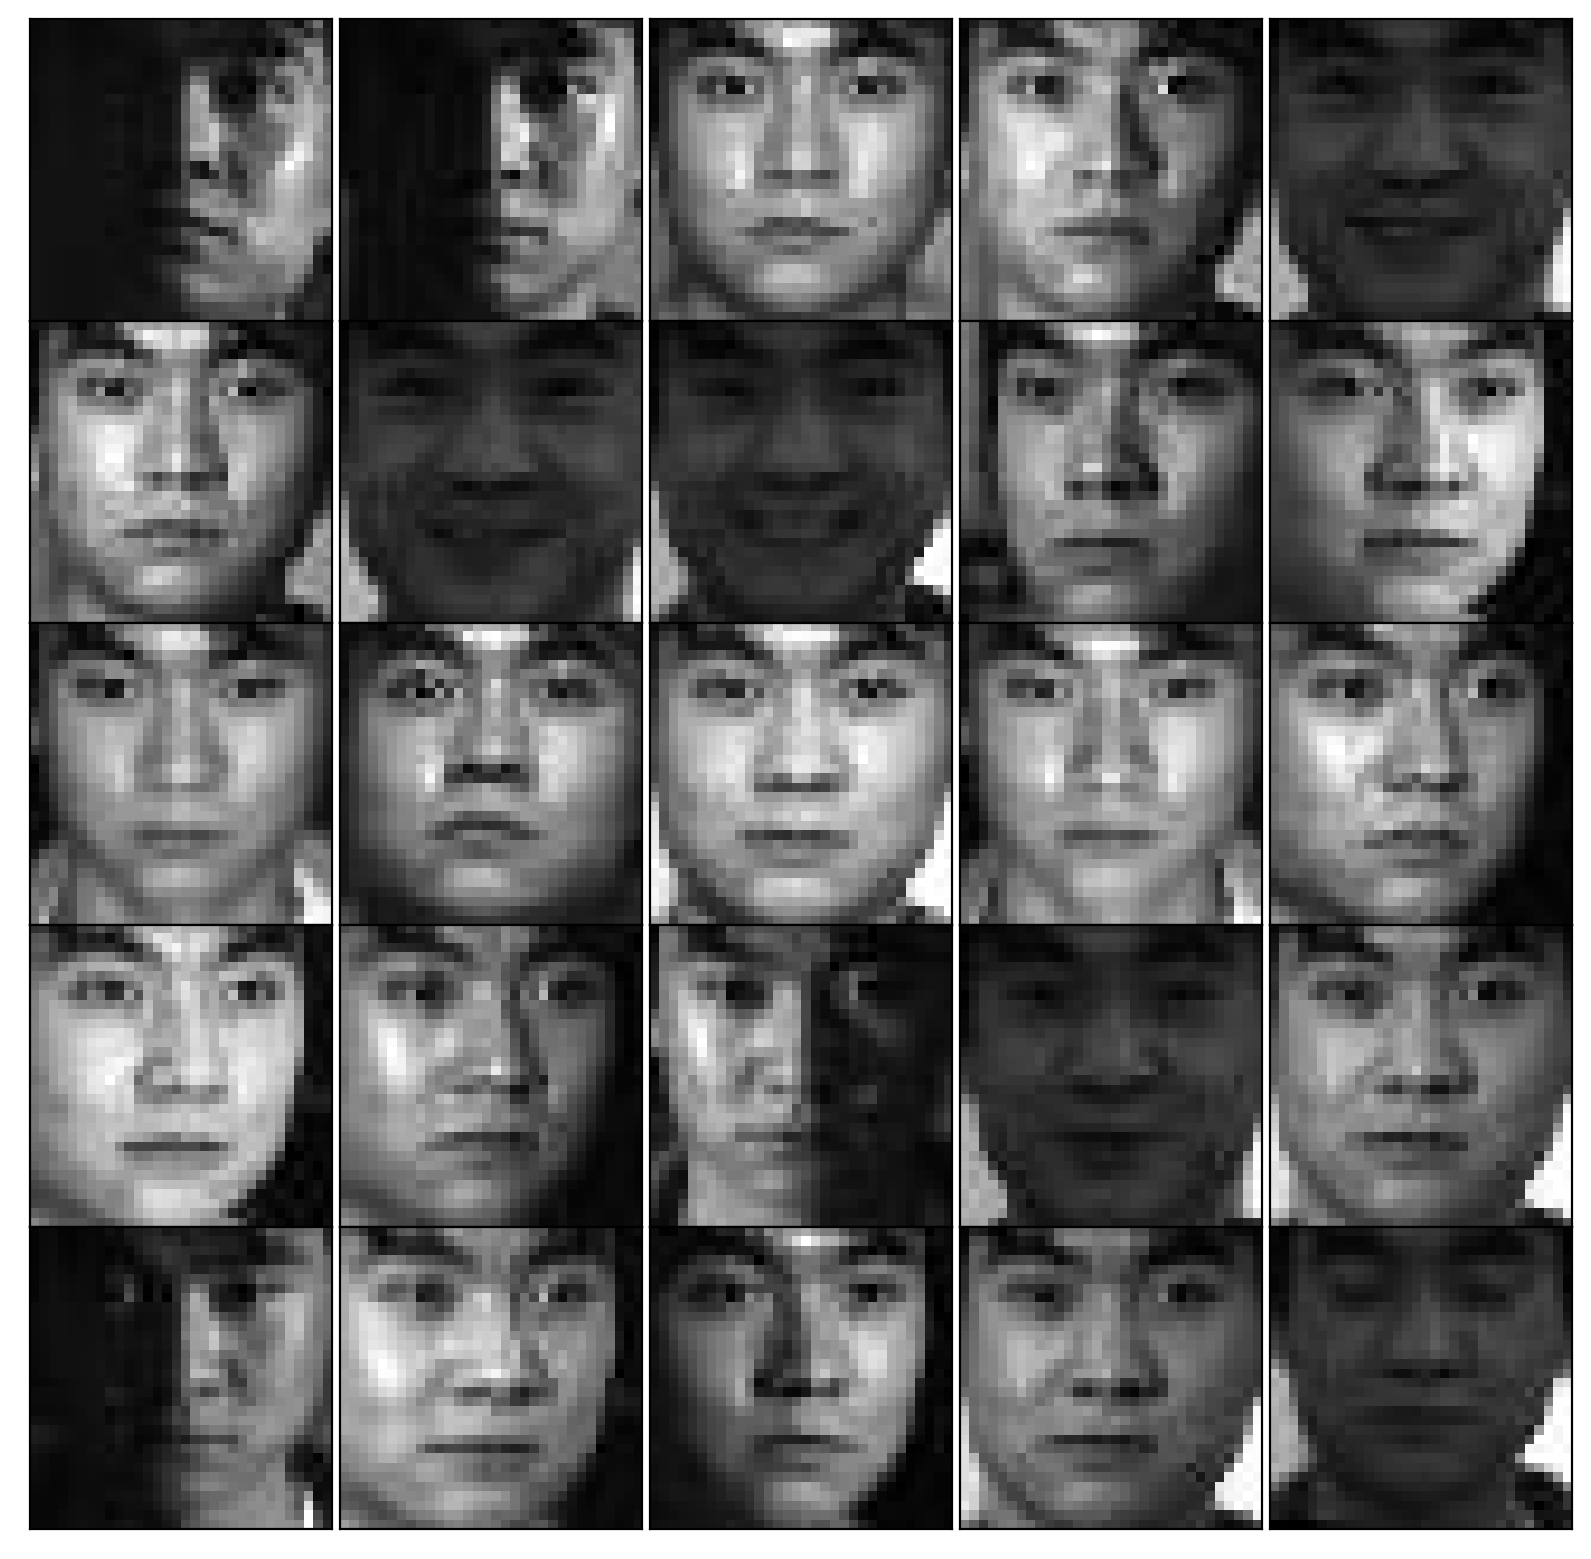

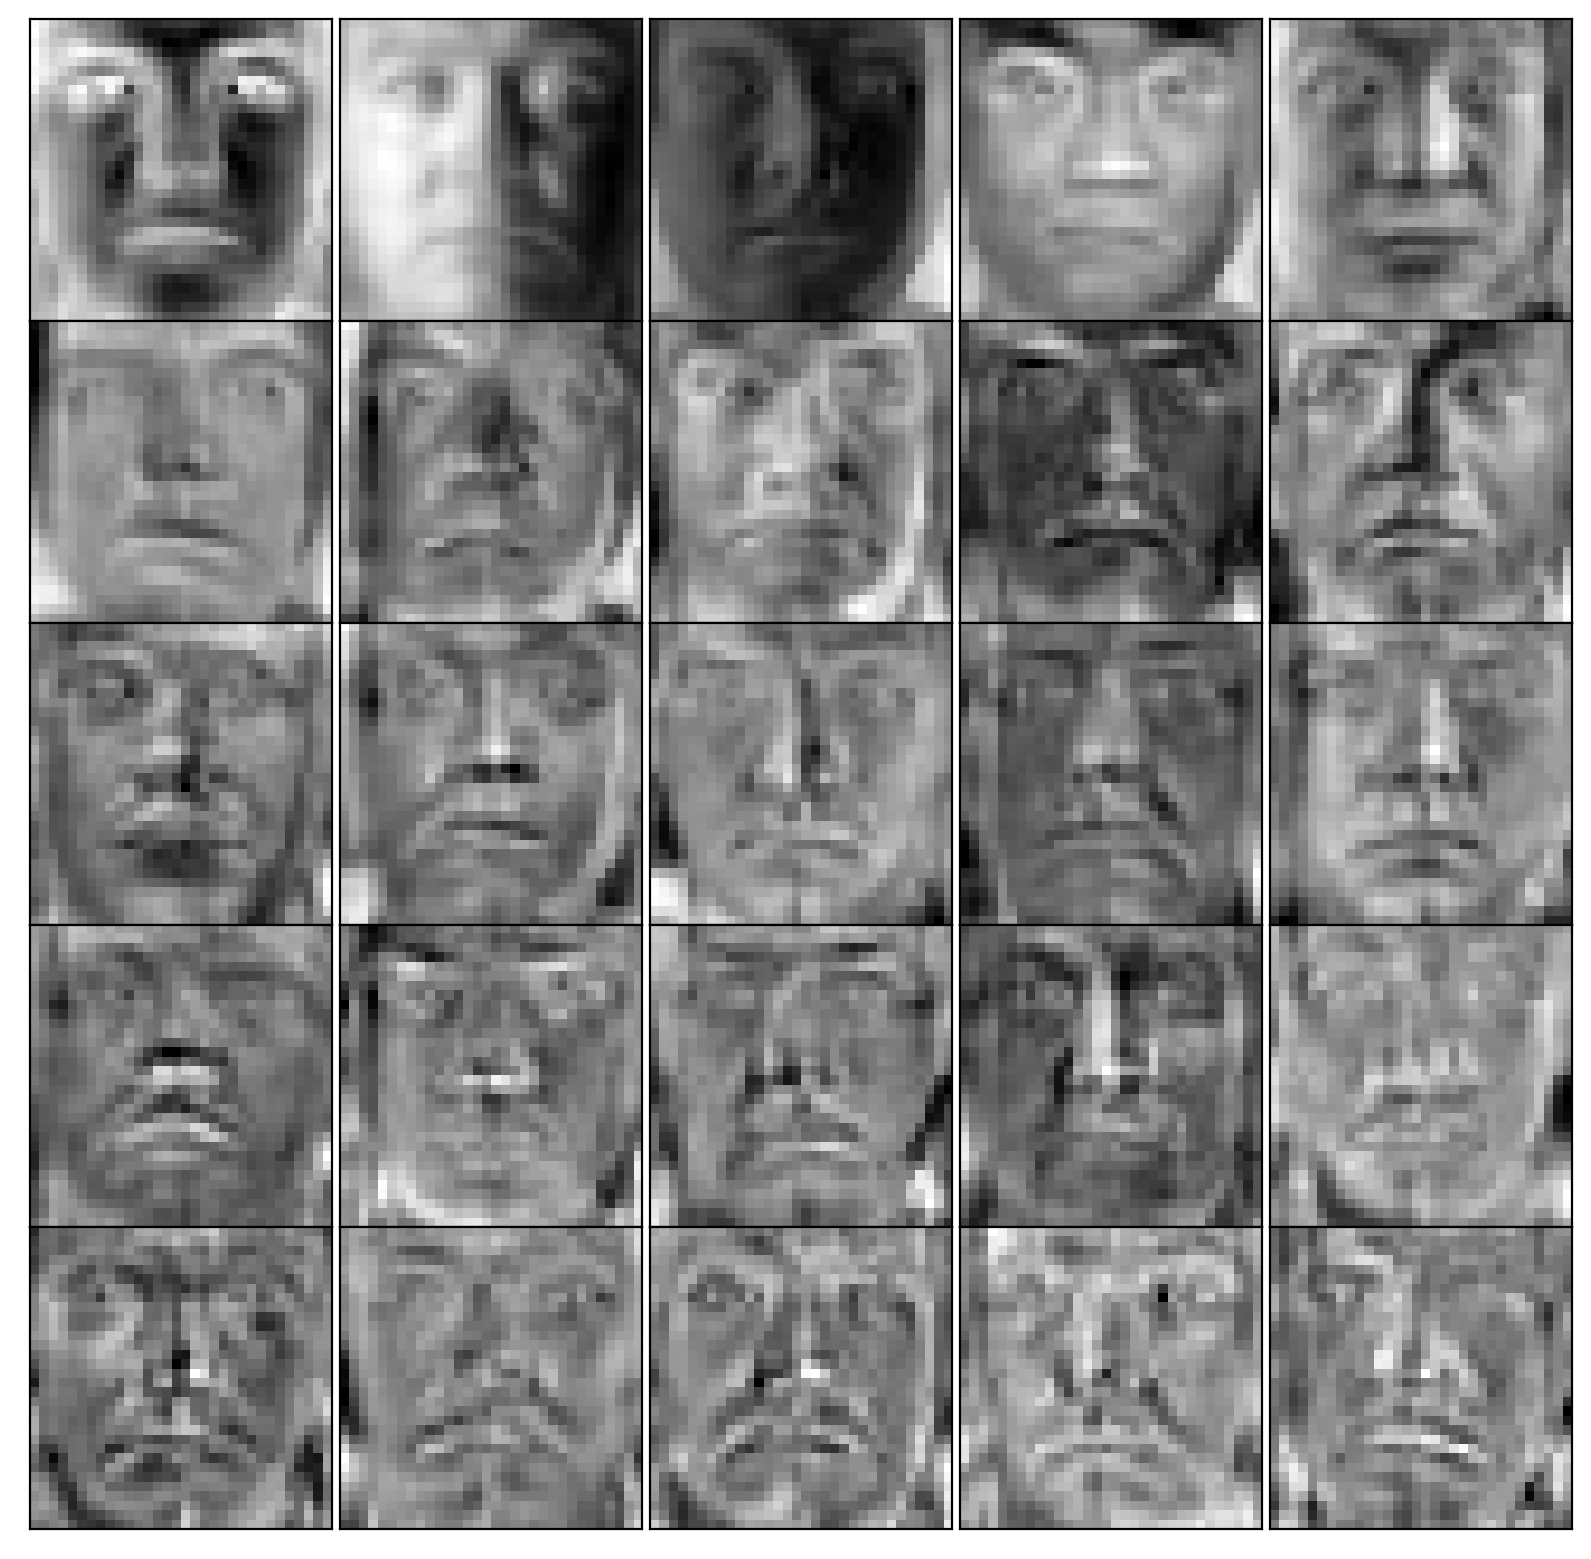

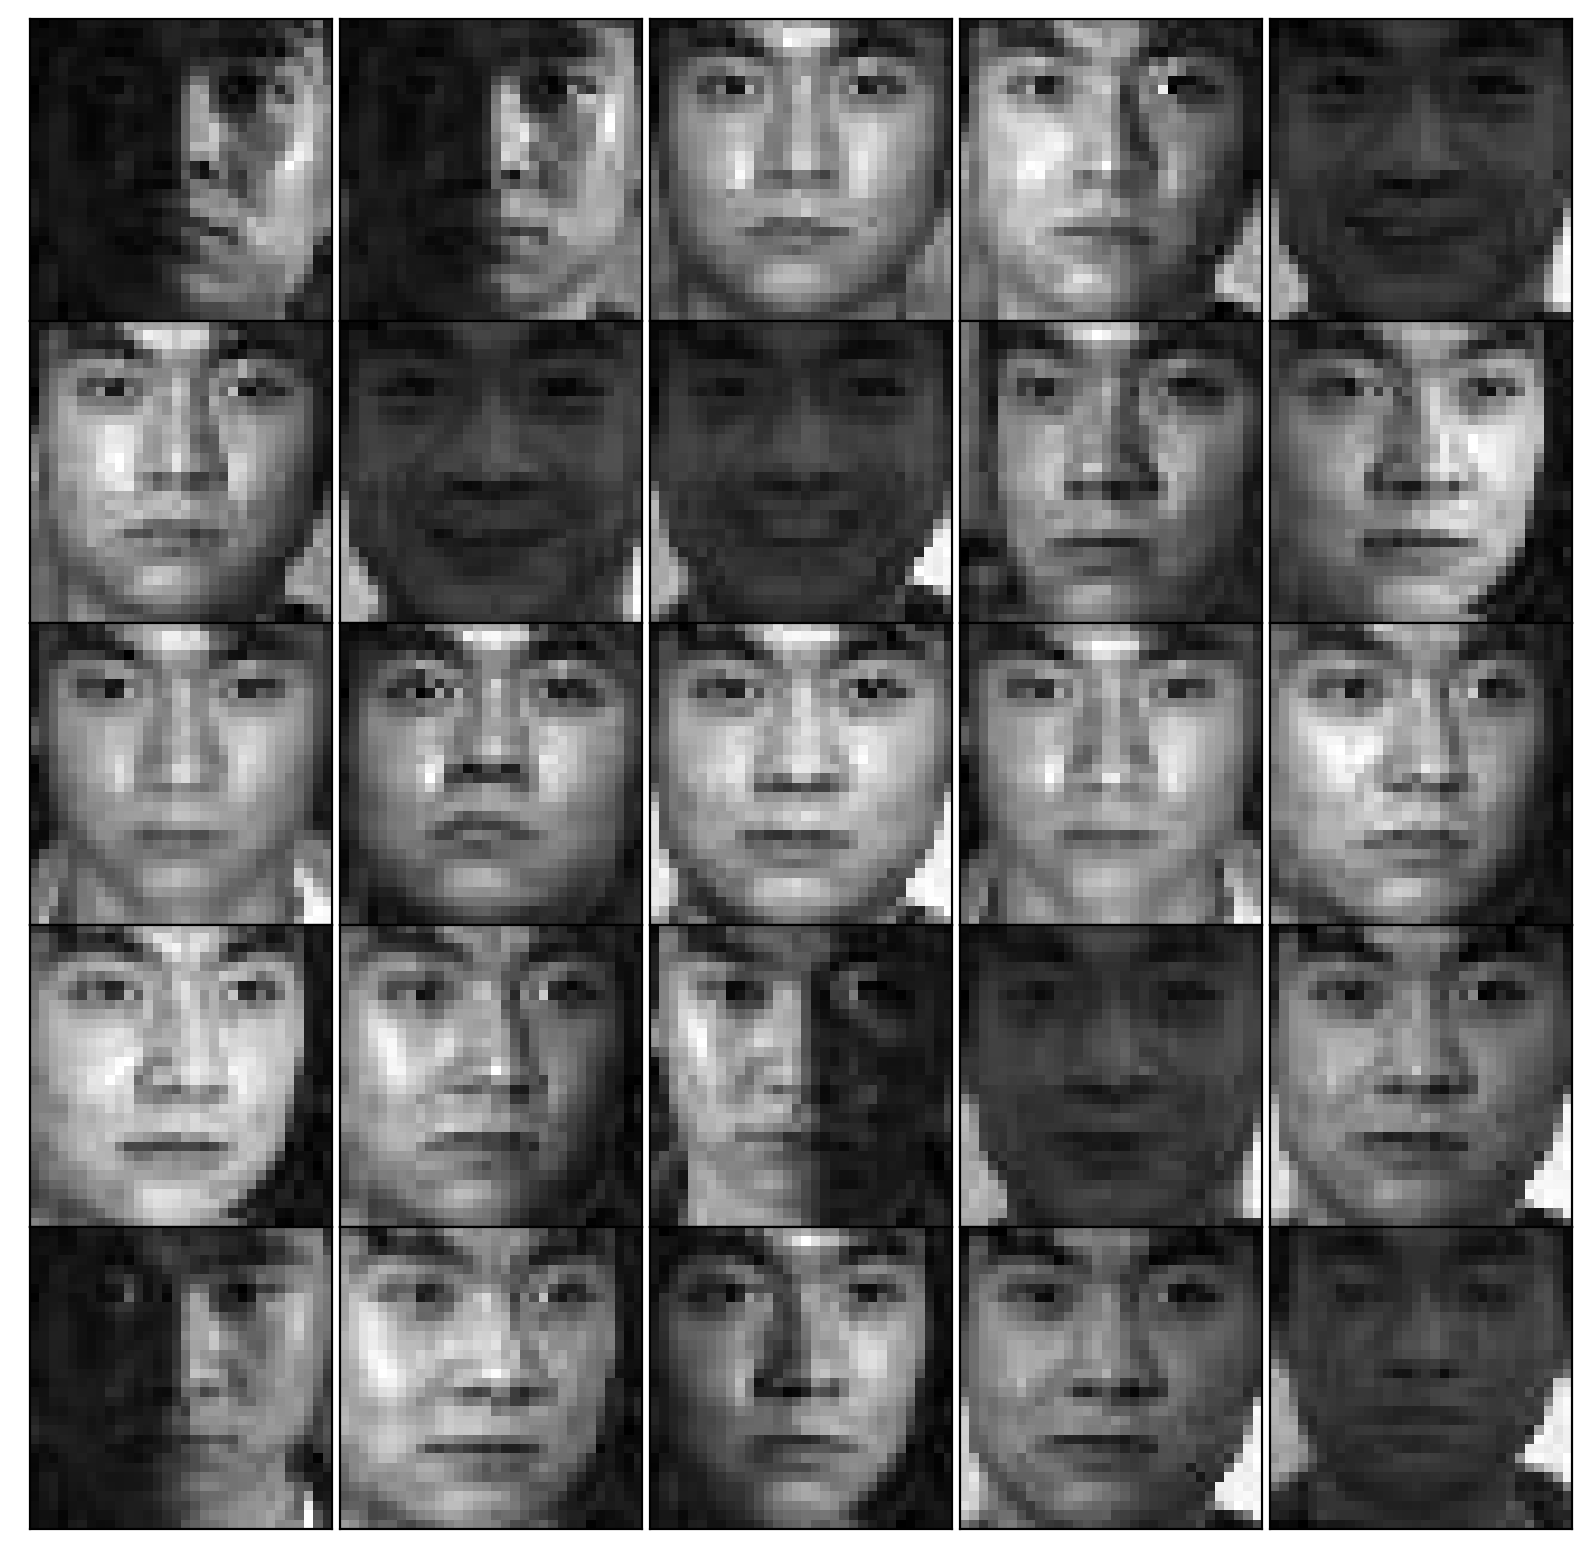

In [198]:
x_pca = PCA(samples)
x_pca.plot_raw()
x_pca.reduce_dim()
x_pca.recon()
x_pca.plot_pc()
x_pca.plot_recon()

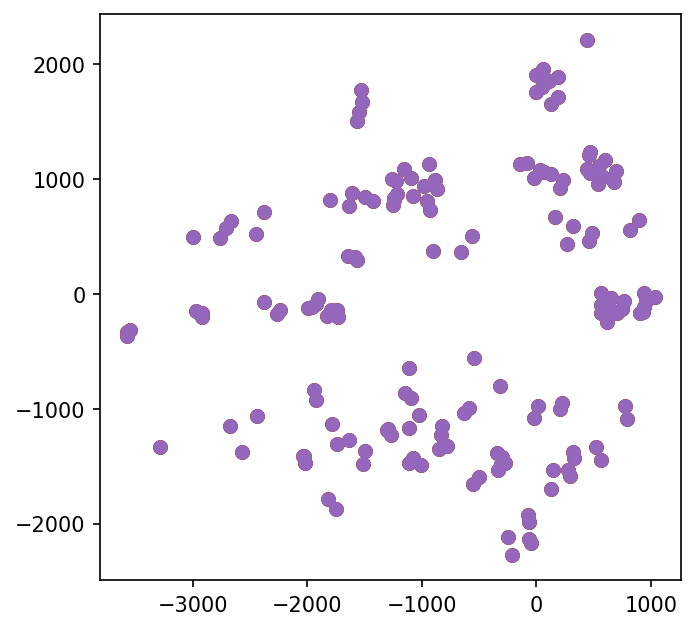

In [112]:
plt.figure(figsize = (5,5),dpi = 150)

for obj in set(labels):
    count = labels.count(obj)
    plt.scatter(samples_pca[0:count,0], samples_pca[0:count,1] )

# LDA

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
    
    def transform(self,X,y):
        height, width = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        scatter_t = np.cov(X.T)*(height - 1)
        scatter_w = 0
        for i in range(num_classes):
            class_items = np.flatnonzero(y == unique_classes[i])
            scatter_w = scatter_w + np.cov(X[class_items].T) * (len(class_items)-1)
        
        scatter_b = scatter_t - scatter_w
        _, eig_vectors = np.linalg.eigh(np.linalg.pinv(scatter_w).dot(scatter_b))
        print(eig_vectors.shape)
        pc = X.dot(eig_vectors[:,::-1][:,:self.n_components])
        print(pc.shape)

        if self.n_components == 2:
            if y is None:
                plt.scatter(pc[:,0],pc[:,1])
            else:
                colors = ['r','g','b']
                labels = np.unique(y)
                for color, label in zip(colors, labels):
                    class_data = pc[np.flatnonzero(y==label)]
                    plt.scatter(class_data[:,0],class_data[:,1],c=color)
            plt.show()
        return pc

(4, 4)
(120, 2)


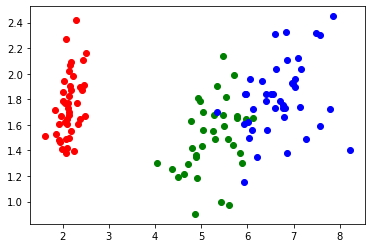

Original Data Size: (120, 4) 
Modified Data Size: (120, 2)


In [191]:
LDA_obj = LDA(n_components=2)
data = load_iris()
X, y = data.data, data.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

LDA_object = LDA(n_components=2)
X_train_modified = LDA_object.transform(X_train, Y_train)

print("Original Data Size:",X_train.shape, "\nModified Data Size:", X_train_modified.shape)

In [ ]:
class LDA:
    def __init__(self, n_components=7):
        self.n_components = n_components
        self.eig_vectors = None
    
    def transform(self,X,y):
        height, width = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        scatter_t = np.cov(X.T)*(height - 1)
        scatter_w = 0
        for i in range(num_classes):
            class_items = np.flatnonzero(y == unique_classes[i])
            scatter_w = scatter_w + np.cov(X[class_items].T) * (len(class_items)-1)
        
        scatter_b = scatter_t - scatter_w
        _, eig_vectors = np.linalg.eigh(np.linalg.pinv(scatter_w).dot(scatter_b))
        print(eig_vectors.shape)
        pc = X.dot(eig_vectors[:,::-1][:,:self.n_components])
        print(pc.shape)

        if self.n_components == 2:
            if y is None:
                plt.scatter(pc[:,0],pc[:,1])
            else:
                colors = ['r','g','b']
                labels = np.unique(y)
                for color, label in zip(colors, labels):
                    class_data = pc[np.flatnonzero(y==label)]
                    plt.scatter(class_data[:,0],class_data[:,1],c=color)
            plt.show()
        return pc